# **Smart Waste Management: Object Classification for Recycling Optimization using Computer Vision and Deep Learning**

### **Introduction**

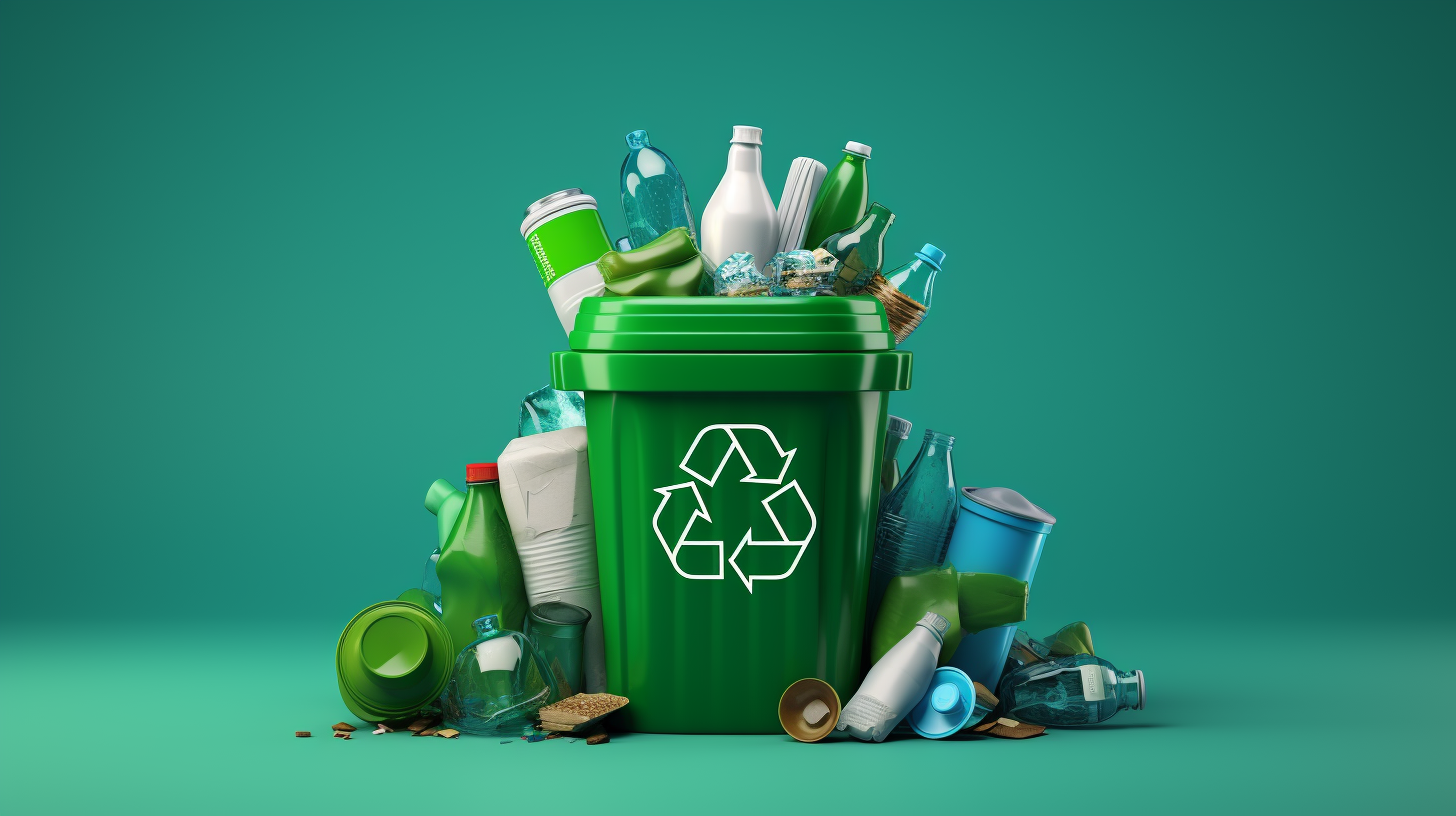

Waste poses a critical global challenge exacerbated by the growing global population and rising living standards. This trend leads to an escalating volume of waste, prompting heightened public concern about its production and impacts, driving a search for effective solutions.

Recycling stands out as a pivotal process within this context. It involves transforming waste materials into new products or raw materials, often incorporating energy recovery methods. The feasibility of recycling hinges on a material's ability to regain its original properties, making it an eco-friendly alternative to traditional waste disposal methods. By conserving materials and reducing the need for fresh raw materials, recycling plays a crucial role in cutting down energy consumption, mitigating air pollution linked to incineration, and curbing water pollution associated with landfill use.

In essence, recycling not only minimizes the squandering of potentially valuable resources but also fosters sustainability by lessening greenhouse gas emissions and environmental strain. Embracing recycling not only addresses immediate waste management concerns but also sets a sustainable course towards preserving our planet's resources for future generations.

 **🟢 In this notebook, we will classify waste as organic or recyclable by combining the Convolutional Neural Network (CNN) + Recurrent Neural Network (RNN) based architectures.**

#### **1. Imports the Required Libraries**

In [1]:
# For Data Processing
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For ML Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Flatten, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# For Data Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

# Miscellaneous
import os
import pathlib
import itertools

#### **2. Loading of the of Waste Management image Dataset**

In [2]:
# Function to create dataframe from data_path
def create_dataframe(data_path):
    # Initialize empty lists for file paths and labels
    filepaths = []
    labels = []
    
    # Get list of subdirectories (folds) in data_path
    folds = os.listdir(data_path)

    # Iterate over each subdirectory (fold)
    for fold in folds:
        # Construct full path to the current fold
        fold_path = os.path.join(data_path, fold)
        # Get list of files in the current fold
        filelists = os.listdir(fold_path)

        # Iterate over each file in the fold
        for file in filelists:
            # Construct full path to the file
            filepaths.append(os.path.join(fold_path, file))
            # Assign label based on fold name
            labels.append(fold)

    # Create pandas Series for filepaths and labels
    filepaths_series = pd.Series(filepaths, name='filepaths')
    labels_series = pd.Series(labels, name='label')
    
    # Concatenate filepaths and labels Series into a DataFrame
    dataframe = pd.concat([filepaths_series, labels_series], axis=1)
    return dataframe

In [3]:
# Define paths for training and testing data
train_data_path = "DATASET/TRAIN/"
train_dataset_path = pathlib.Path(train_data_path)
train_dataset_contains = os.listdir(train_dataset_path) 
print("Training Dataset Contains: ",*train_dataset_contains,sep='\n\t\t\t')

test_data_path = "DATASET/TEST/"
test_dataset_path = pathlib.Path(test_data_path)
test_dataset_contains = os.listdir(test_dataset_path) 
print("\nTesting Dataset Contains: ",*test_dataset_contains,sep='\n\t\t\t')

Training Dataset Contains: 
			O
			R

Testing Dataset Contains: 
			O
			R


In [4]:
# Create DataFrame for training data
train_df = create_dataframe(train_data_path)

In [5]:
# Create DataFrame for testing data
test_df = create_dataframe(test_data_path)

#### **3. Exploratory Data Analysis (EDA) of the of Waste Management image Dataset**

In [6]:
# view the first five values of the training data
train_df.head()

filepaths label
0      DATASET/TRAIN/O\O_1.jpg     O
1     DATASET/TRAIN/O\O_10.jpg     O
2    DATASET/TRAIN/O\O_100.jpg     O
3   DATASET/TRAIN/O\O_1000.jpg     O
4  DATASET/TRAIN/O\O_10000.jpg     O

In [7]:
# view the last five values of the training data
train_df.tail()

filepaths label
22559  DATASET/TRAIN/R\R_9995.jpg     R
22560  DATASET/TRAIN/R\R_9996.jpg     R
22561  DATASET/TRAIN/R\R_9997.jpg     R
22562  DATASET/TRAIN/R\R_9998.jpg     R
22563  DATASET/TRAIN/R\R_9999.jpg     R

In [8]:
# view the first five values of the testing data
test_df.head()

filepaths label
0  DATASET/TEST/O\O_12568.jpg     O
1  DATASET/TEST/O\O_12569.jpg     O
2  DATASET/TEST/O\O_12570.jpg     O
3  DATASET/TEST/O\O_12571.jpg     O
4  DATASET/TEST/O\O_12572.jpg     O

In [9]:
# view the last five values of the testing data
test_df.tail()

filepaths label
2508  DATASET/TEST/R\R_11107.jpg     R
2509  DATASET/TEST/R\R_11108.jpg     R
2510  DATASET/TEST/R\R_11109.jpg     R
2511  DATASET/TEST/R\R_11110.jpg     R
2512  DATASET/TEST/R\R_11111.jpg     R

In [10]:
print(f'Total Images Train set: {len(train_df)}')

Total Images Train set: 22564


In [11]:
print(f'Total Images Test set: {len(test_df)}')

Total Images Test set: 2513


In [12]:
# Let's find the number of classes we have in train dataset.
# Retrieve and sort the list of classes
CLASSES = sorted(os.listdir(train_data_path))

# Print the header
print("=" * 40)
print("Total Classes in Training Dataset")
print("=" * 40)

# Print each class name on a new line
for i, class_name in enumerate(CLASSES, start=1):
    if class_name == 'O':
        print(f"{i}. {class_name} means Organic")
    else:
        print(f"{i}. {class_name} means Recyclable")
# Print the total number of classes
print("=" * 40)
print(f"Total Classes: {len(CLASSES)}")
print("=" * 40)

Total Classes in Training Dataset
1. O means Organic
2. R means Recyclable
Total Classes: 2


In [13]:
# Let's find the number of classes we have in Test dataset.
# Retrieve and sort the list of classes
CLASSES = sorted(os.listdir(test_data_path))

# Print the header
print("=" * 40)
print("Total Classes in Testing Dataset")
print("=" * 40)

# Print each class name on a new line
for i, class_name in enumerate(CLASSES, start=1):
    if class_name == 'O':
        print(f"{i}. {class_name} means Organic")
    else:
        print(f"{i}. {class_name} means Recyclable")
# Print the total number of classes
print("=" * 40)
print(f"Total Classes: {len(CLASSES)}")
print("=" * 40)

Total Classes in Testing Dataset
1. O means Organic
2. R means Recyclable
Total Classes: 2


In [14]:
# function to plot & Visualize the class ditribution 
def visualize_class_distribution(df, dataset_name):
    """
    Visualize class distribution in a dataset interactively using Plotly.
    
    Args:
    df (DataFrame): DataFrame containing the dataset.
    dataset_name (str): Name of the dataset.
    """
    # Calculate class counts
    class_counts = df['label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    
    # Map class labels to more descriptive names
    class_counts['Class'] = class_counts['Class'].map({'O': 'Organic', 'R': 'Recyclable'})
    
    # Create a pie chart using Plotly Express
    fig = px.pie(class_counts,                        # DataFrame with data
                 values='Count',                      # Column to use for wedge sizes
                 names='Class',                       # Column to use for wedge labels
                 title=f"Number of Images in Each Class in {dataset_name}",  # Chart title
                 width=700, height=500,               # Size of the chart
                 color_discrete_sequence=px.colors.qualitative.Dark24,  # Color scheme
                 hole=0.4)                            # Size of the hole in the middle of the pie
    
    # Update the traces to show percentage and label inside the pie wedges
    fig.update_traces(textposition='inside', textinfo='percent+label')
    
    # Update layout settings
    fig.update_layout(
        title=dict(
            text=f"Number of Images in Each Class in {dataset_name}",  # Title text
            x=0.5, y=0.95,                      # Title position
            font=dict(size=20)                 # Title font size
        ),
        legend=dict(
            orientation="h",                   # Legend orientation (horizontal)
            yanchor="bottom",                  # Anchor point for y position
            y=1.02,                            # Y position of the legend
            xanchor="right",                   # Anchor point for x position
            x=1                                # X position of the legend
        ),
        margin=dict(l=20, r=20, t=80, b=20),    # Margin settings
        paper_bgcolor='rgba(0,0,0,0)',          # Background color for the plot area
        plot_bgcolor='rgba(0,0,0,0)',           # Background color for the entire plot
        font=dict(family="Arial", size=12)      # Font settings
    )
    
    # Show the interactive plot
    fig.show()

In [15]:
# Class Distribution for the Training Dataset
print("Training Dataset:")
visualize_class_distribution(train_df, "Training Dataset")

Training Dataset:


In [16]:
# Class Distribution for the Testing Dataset
print("\nTest Dataset:")
visualize_class_distribution(test_df, "Test Dataset")


Test Dataset:


In [17]:
# Function to plot and visualize the sample image of the classes 
def visualize_random_sample_images(data_df, show_imgs=15):
    """
    Visualize a random sample of images from the dataset.
    
    Args:
    data_df (DataFrame): DataFrame containing file paths and labels.
    show_imgs (int): Number of images to display.
    """
    # Define class labels
    class_labels = {'O': 'Organic', 'R': 'Recyclable'}
    
    # Randomly select indices from the DataFrame
    idx = np.random.randint(0, len(data_df), size=show_imgs)
    
    # Create subplots grid with specified number of rows and columns
    fig, axes = plt.subplots(show_imgs // 5, 5, figsize=(15, 10))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Iterate over each subplot and display an image with its corresponding label
    for i, ax in enumerate(axes):
        if i < show_imgs:
            # Get the full path of the image file
            full_path = data_df.iloc[idx[i]]['filepaths']
            
            # Display the image
            img = plt.imread(full_path)
            ax.imshow(img)
            
            # Determine and set the title of the image subplot with its class label
            class_label = data_df.iloc[idx[i]]['label']
            ax.set_title(f"Class: {class_labels[class_label]}", fontsize=12, fontweight = 'bold')
            
            # Hide the axis
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any extra subplots if show_imgs is not a multiple of 5
    
    # Add a title to the entire figure
    fig.suptitle("Random Sample of Images", fontsize=16, fontweight='bold')
    
    # Adjust layout to prevent overlap between title and subplots
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # Adjusted layout
    
    # Show the plot
    plt.show()

Sample Images from Training Dataset:


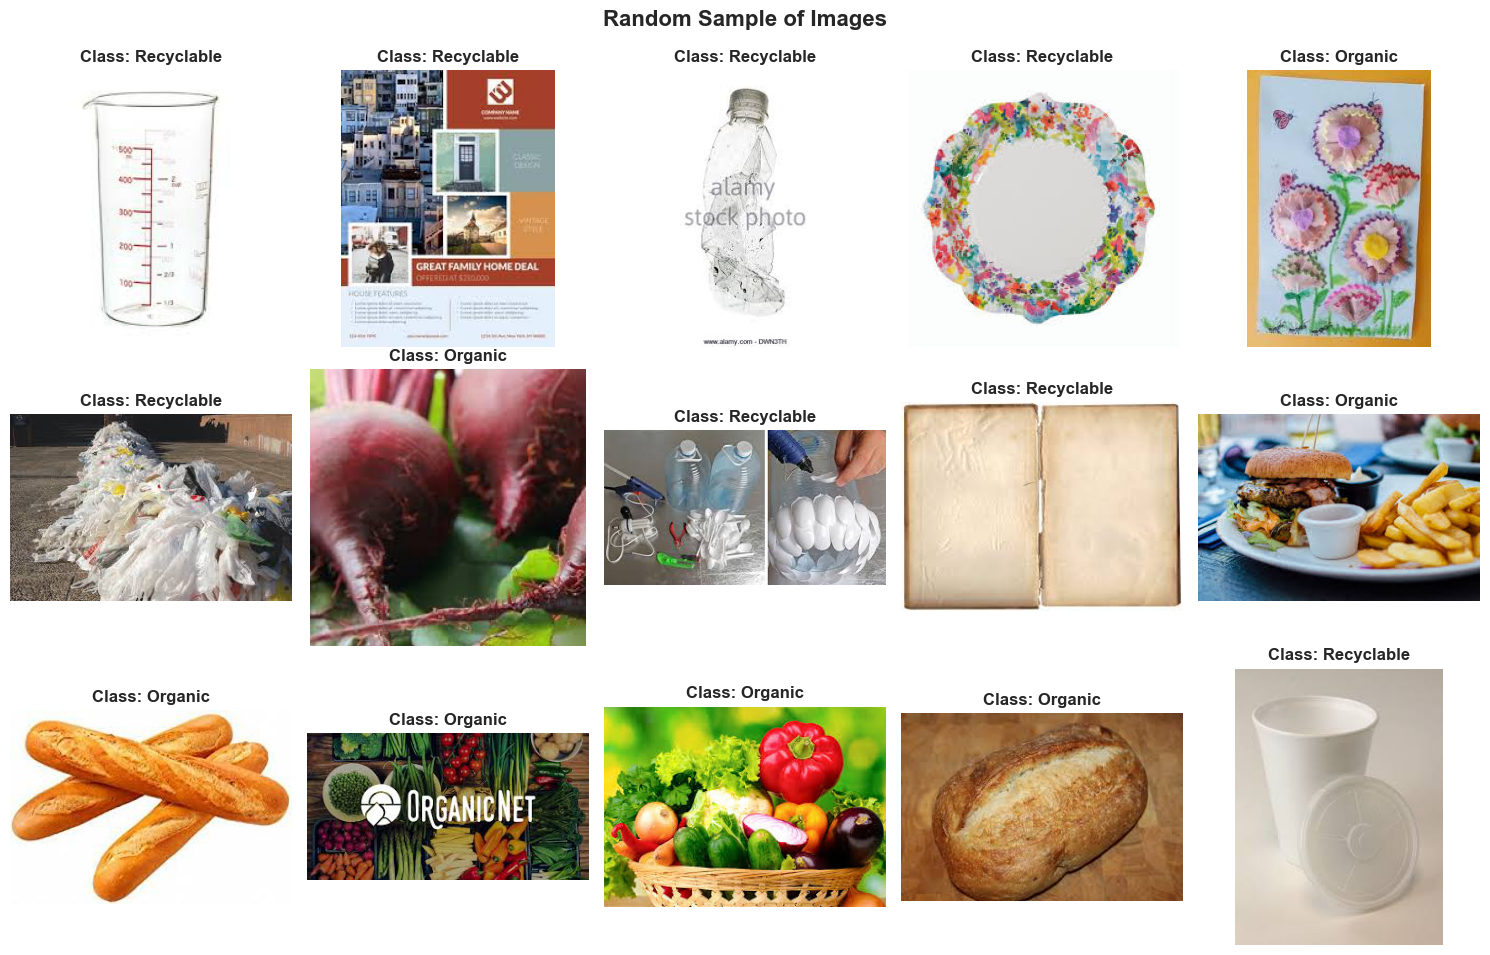

In [18]:
# Visualize sample images from training data
print("Sample Images from Training Dataset:")
visualize_random_sample_images(train_df)

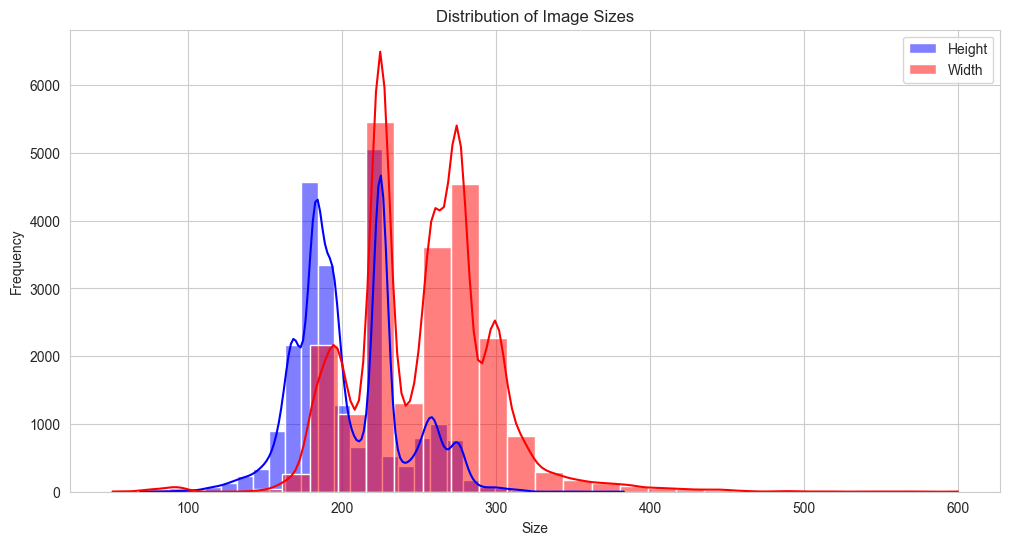

In [19]:
# Plot distribution of image sizes in the dataset
def plot_image_sizes(data_df):
    sizes = []
    for image_path in data_df['filepaths']:
        image = cv2.imread(image_path)
        sizes.append(image.shape)
    sizes_df = pd.DataFrame(sizes, columns=['height', 'width', 'channels'])
    plt.figure(figsize=(12, 6))
    sns.histplot(sizes_df['height'], bins=30, kde=True, color='b', label='Height')
    sns.histplot(sizes_df['width'], bins=30, kde=True, color='r', label='Width')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Sizes')
    plt.legend()
    plt.show()

# Plot distribution of image sizes in the dataset
plot_image_sizes(train_df)

#### **4. Splitting and Preprocessing of the Waste Image Dataset (Preprocess the images (resizing, normalization, etc.).)**

In [20]:
# Splitting the data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

In [21]:
# Image Data Generator setup
img_size = (224, 224)
batch_size = 16

In [22]:
# Train Data Generator
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [23]:
# Train Data Generator setup
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Validation Data Generator setup
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Test Data Generator setup
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 22564 validated image filenames belonging to 2 classes.
Found 1256 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.


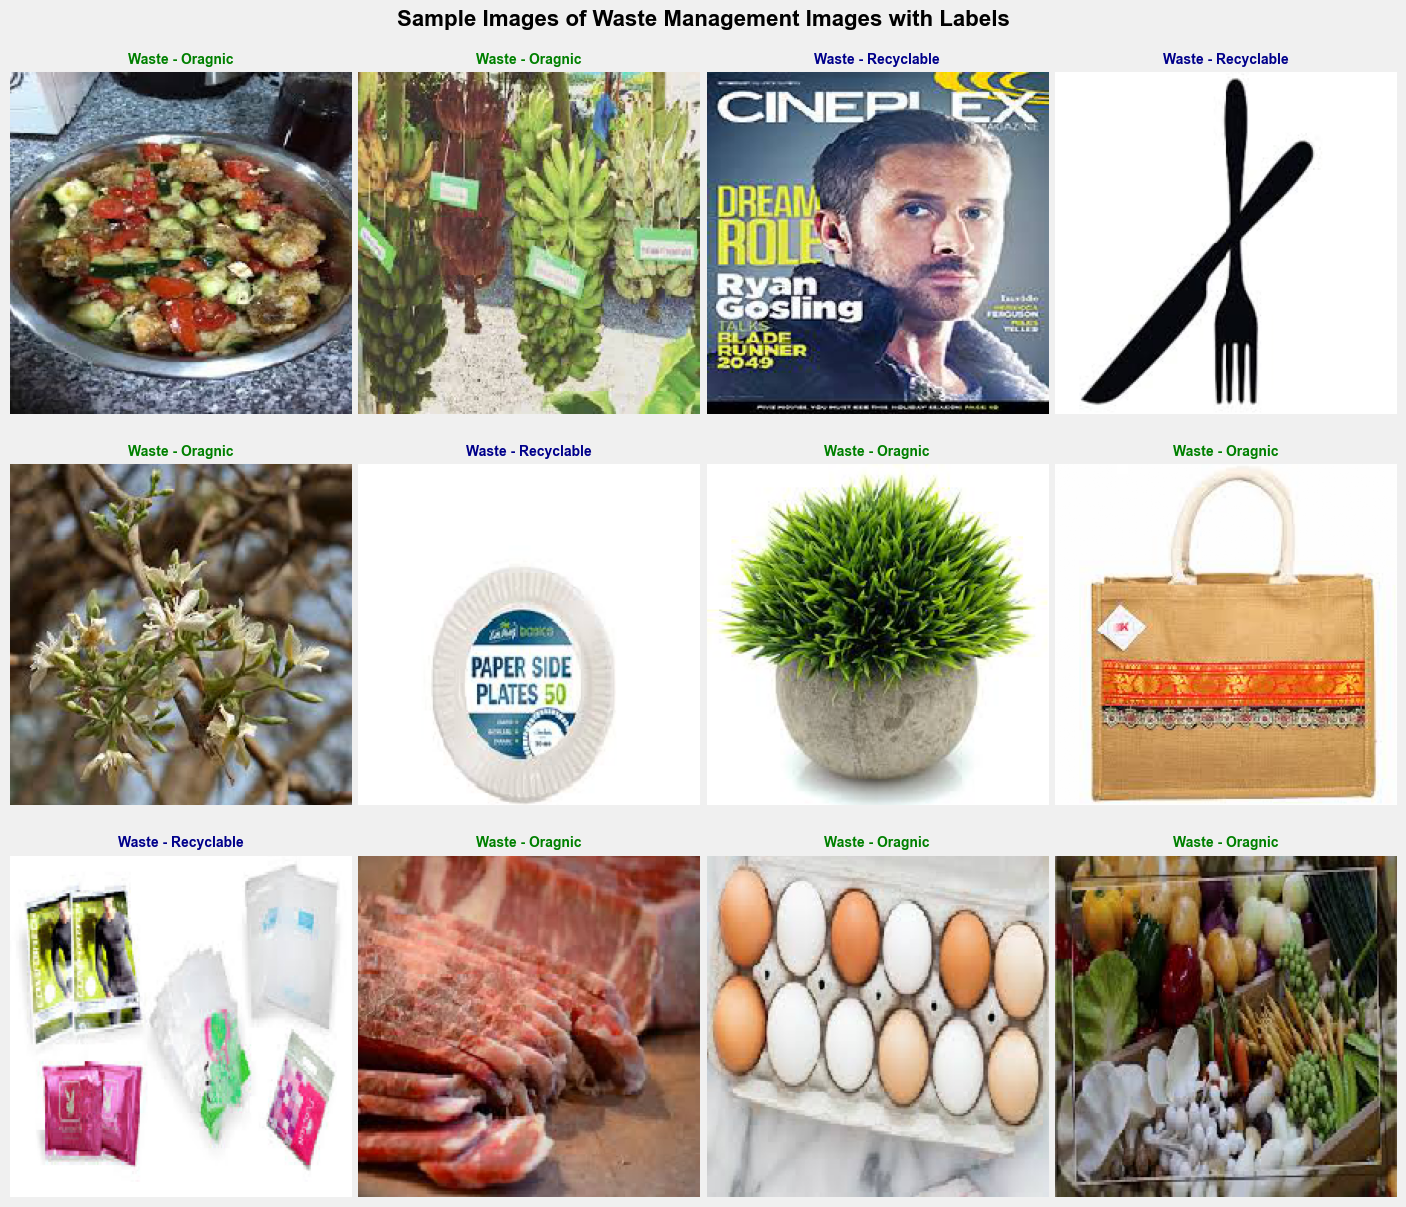

In [24]:
# Get class indices dictionary
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())

# Get a batch of images and labels from the training generator
images, labels = next(train_gen)

# Plot a grid of 12 sample images with their corresponding labels
plt.figure(figsize=(14, 12))  # Adjusted figure size to match the provided plot
for i in range(12):  # Showing 12 samples as per your original code
    # Normalize image
    image = images[i] / 255
    
    # Plot each image in a subplot
    plt.subplot(3, 4, i + 1)  # Adjusted subplot layout to match the provided plot
    plt.imshow(image)
    
    # Get the index of the label and its corresponding class name
    index = np.argmax(labels[i])
    class_name = classes[index]
    
    # Set title with class name
    if class_name == 'O':
        plt.title("Waste -"+" Oragnic", color='green', fontsize=10, fontweight = 'bold')
    else:
        plt.title("Waste -"+" Recyclable", color='darkblue', fontsize=10,fontweight = 'bold')  # Adjusted title color to match the provided plot
    plt.axis('off')

# Adjusting layout
plt.tight_layout(pad=0.5)

# Adding a title with adjusted vertical position
plt.suptitle("Sample Images of Waste Management Images with Labels", y=1.02, fontsize=16, color='black', fontweight='bold')

# Adding background color and grid
plt.gcf().set_facecolor('#f0f0f0')
plt.grid(False)

plt.show()


#### **5. Model Building: CNN (ResNet50 model) and RNN Combination**

**ResNet50 Model:**
`ResNet50 is a convolutional neural network architecture that belongs to the ResNet (Residual Network) family. It consists of 50 layers and is particularly well-known for its effectiveness in image classification tasks. ResNet50 is characterized by the use of residual blocks, which allow for the training of very deep neural networks without suffering from vanishing gradient problems. These residual blocks contain shortcut connections that skip one or more layers, facilitating the flow of gradients during training.`

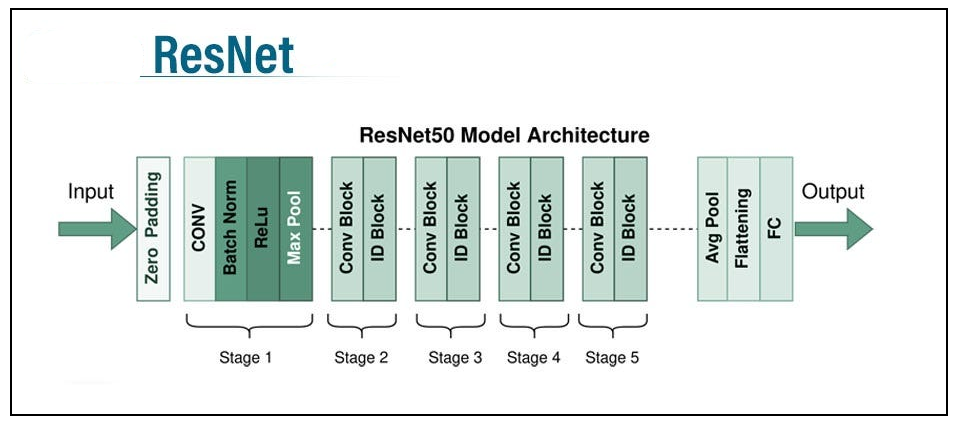

Combining CNN (Convolutional Neural Network) and RNN (Recurrent Neural Network) architectures can be particularly effective for tasks that involve both spatial and temporal dependencies in data. Here’s how the model architecture we discussed performs the combination:

#### **Architecture Overview:**

1. **CNN (ResNet50 Base):**
   - The ResNet50 model is used as the CNN component. It is a deep convolutional neural network that is excellent at extracting hierarchical features from images. In this architecture, we leverage its pre-trained weights (from ImageNet) and its ability to capture spatial features through convolutional layers.

2. **Combination with RNN (LSTM):**
   - After extracting features using ResNet50, the output is processed by an RNN component, specifically an LSTM (Long Short-Term Memory) layer. The purpose of the LSTM here is to capture temporal dependencies in the sequence of feature vectors extracted by ResNet50.
   - The LSTM layer processes the flattened and reshaped output of ResNet50 across time steps. This is crucial for tasks where the order of image sequences or temporal features matters, such as video classification or sequential image processing tasks.

3. **Model Output:**
   - The output from the LSTM layer is then fed into additional dense layers for further processing and classification. Regularization techniques such as dropout and regularization terms (L1, L2) are applied to prevent overfitting and improve generalization.
   - Finally, a softmax activation function is used in the output layer to produce class probabilities, making the model suitable for multi-class classification tasks.

#### **Benefits of Combining CNN and RNN:**

- **Feature Extraction:** CNNs are powerful in extracting spatial features from images due to their hierarchical feature learning capabilities.
- **Temporal Dependencies:** RNNs, especially LSTM variants, excel in capturing sequential dependencies over time, making them suitable for tasks where order or temporal context is important.
- **Complementary Strengths:** By combining these architectures, the model can leverage both spatial and temporal information inherent in the data, leading to potentially higher accuracy and better performance for tasks like action recognition in videos, gesture recognition, or any sequence-based image analysis.


By leveraging the strengths of both CNNs and RNNs in a unified architecture, we can build robust models capable of handling complex data patterns that involve both spatial and temporal contexts. Adjustments to the architecture and hyperparameters may be necessary based on the specific characteristics and requirements of your application domain.

In [25]:
# img_size and classes are defined elsewhere
input_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

In [26]:
# Build the ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='max')

In [27]:
# Freeze ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Add layers on top of ResNet50
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# Flatten the output of ResNet50
x = Flatten()(x)

# Reshape for LSTM input
x = Reshape((-1, x.shape[1]))(x)

# LSTM layer to capture temporal dependencies
x = LSTM(128)(x)

# Additional dense layers with regularization and dropout
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)
x = Dropout(rate=0.4, seed=75)(x)

# Output layer
predictions = Dense(num_class, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#### **6. Model Training and Evaluation**

In [29]:
# Train the model
history = model.fit(x=train_gen, epochs=10, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False)

Epoch 1/10

1411/1411 [==============================] - 1190s 841ms/step - loss: 0.5302 - accuracy: 0.9135 - val_loss: 0.3324 - val_accuracy: 0.8885
Epoch 2/10
1411/1411 [==============================] - 1245s 882ms/step - loss: 0.1978 - accuracy: 0.9523 - val_loss: 0.3072 - val_accuracy: 0.8989
Epoch 3/10
1411/1411 [==============================] - 1187s 841ms/step - loss: 0.1416 - accuracy: 0.9702 - val_loss: 0.3928 - val_accuracy: 0.8567
Epoch 4/10
1411/1411 [==============================] - 1201s 851ms/step - loss: 0.1030 - accuracy: 0.9839 - val_loss: 0.3945 - val_accuracy: 0.8670
Epoch 5/10
1411/1411 [==============================] - 1238s 877ms/step - loss: 0.0798 - accuracy: 0.9895 - val_loss: 0.3945 - val_accuracy: 0.8782
Epoch 6/10
1411/1411 [==============================] - 1210s 858ms/step - loss: 0.0654 - accuracy: 0.9933 - val_loss: 0.3947 - val_accuracy: 0.8861
Epoch 7/10
1411/1411 [==============================] - 1234s 875ms/step - loss: 0.0567 - accuracy: 0.995

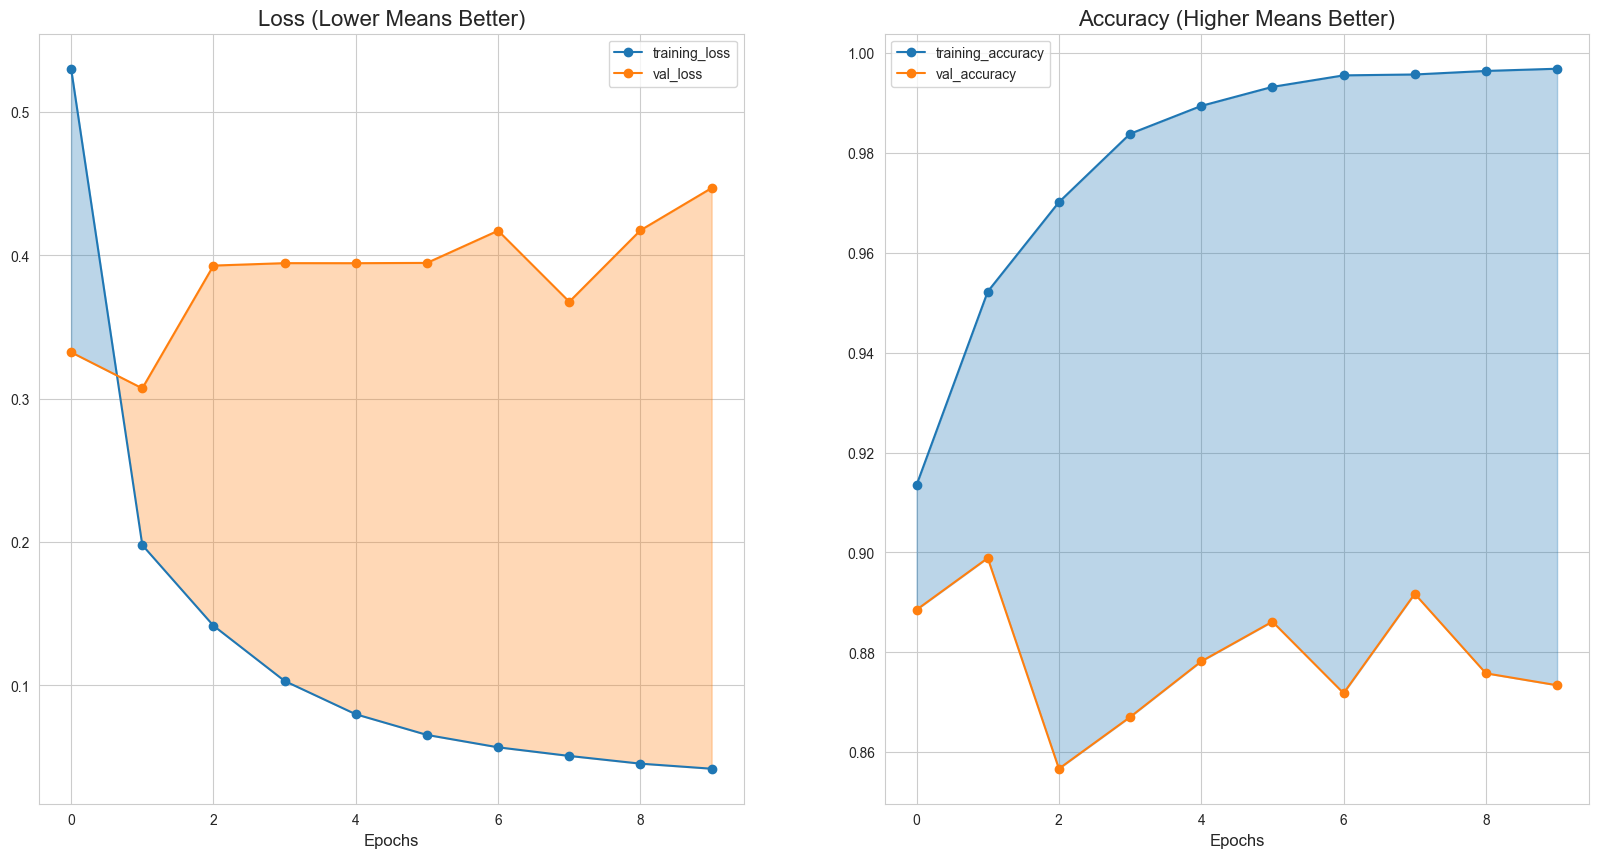

In [30]:
def plot_training_curves(history):
    # Extracting loss and accuracy values from the history object
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    epochs = range(len(history.history['loss']))  # Number of epochs
    
    # Creating subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plotting training and validation loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()
    
    # Plotting training and validation accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()
    
    # Display the plots
    plt.show()

# Plot training curves
plot_training_curves(history)

In [31]:
# Evaluate the model
train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

# Format and print the evaluation results
print("\n" + "="*50)
print("{:<20} {:<10} {:<10}".format("Dataset", "Loss", "Accuracy"))
print("-"*50)
print("{:<20} {:<10.4f} {:<10.4f}".format("Training", train_score[0], train_score[1]))
print("{:<20} {:<10.4f} {:<10.4f}".format("Validation", valid_score[0], valid_score[1]))
print("{:<20} {:<10.4f} {:<10.4f}".format("Testing", test_score[0], test_score[1]))
print("="*50)

16/16 [==============================] - 13s 809ms/step - loss: 0.3827 - accuracy: 0.8945

Dataset              Loss       Accuracy  
--------------------------------------------------
Training             0.0352     0.9961    
Validation           0.4919     0.8555    
Testing              0.3827     0.8945    


79/79 [==============================] - 65s 797ms/step

Classification Report:
              precision    recall  f1-score   support

           O       0.83      0.98      0.90       703
           R       0.97      0.75      0.84       554

    accuracy                           0.88      1257
   macro avg       0.90      0.86      0.87      1257
weighted avg       0.89      0.88      0.88      1257


Confusion Matrix:


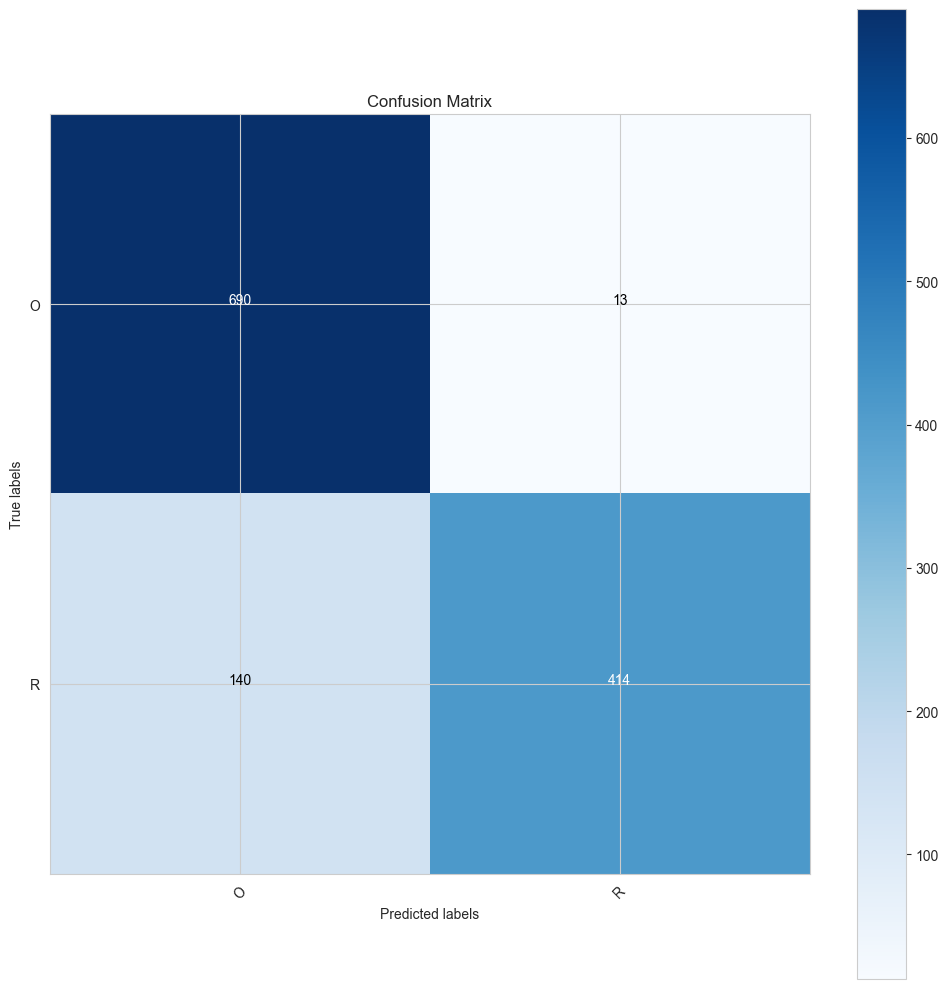

In [32]:
# Classification report and confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=-1)
class_names = list(test_gen.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

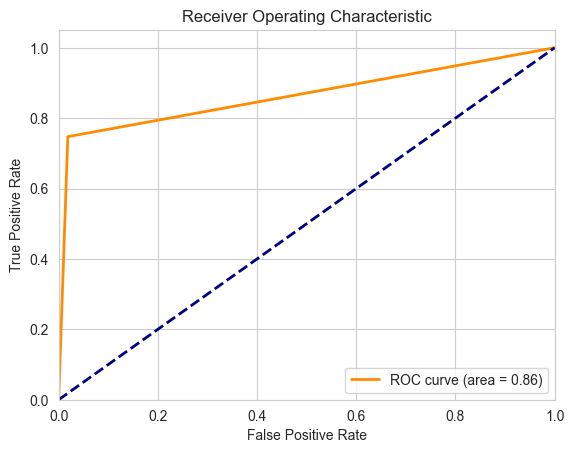

In [33]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### **7. Model Testing**

1/1 [==============================] - 2s 2s/step


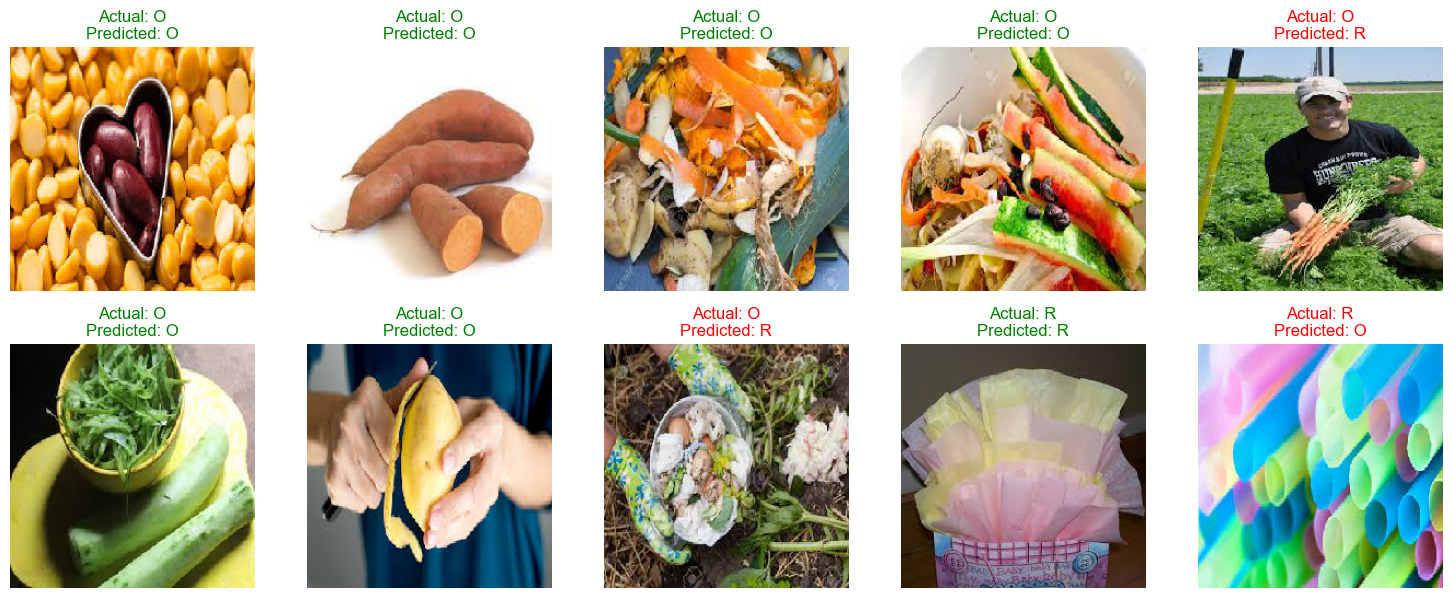

In [34]:
# Plot actual vs predicted images
def plot_predictions(model, test_gen, num_images=10):
    class_names = list(test_gen.class_indices.keys())
    images, labels = next(test_gen)
    predictions = model.predict(images)
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        # Normalize the image before plotting
        image = images[i] / 255
        plt.imshow(image)
        plt.axis('off')
        actual_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}', color=color)
    plt.tight_layout()
    plt.show()

# Plot actual vs predicted images
plot_predictions(model, test_gen)